## ML INTRO PRACTICA (V): Modelado

In [1]:
# Recuperemos lo hecho en la sesión anterior

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from bootcampviztools import plot_combined_graphs
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score




# Código extra para los tamaños de las fuentes y los "ticks" de los ejes, esto no lo vimos al hablar de matplotlib así que una extra
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)


df_inmo = pd.read_csv("./data/ejemplo_housing.csv")

train_set, test_set = train_test_split(df_inmo, test_size=0.2, random_state=42)

train_set["income_cat"] = pd.cut(train_set["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

train_set["rooms_per_house"] = train_set["total_rooms"] / train_set["households"]
train_set["bedrooms_ratio"] = train_set["total_bedrooms"] / train_set["total_rooms"]



target = "median_house_value"

# Procesado de variables categóricas
train_set = pd.get_dummies(train_set, columns = ["ocean_proximity"], dtype = int)

# Procesado de variables numéricas
min_max_scaler = MinMaxScaler(feature_range=(-1, 1))
for col in ["rooms_per_house","total_rooms","bedrooms_ratio"]:
    train_set[f"log_{col}"] = train_set[col].apply(np.log)
    train_set[col] = min_max_scaler.fit_transform(train_set[[f"log_{col}"]])

train_set["housing_median_age"] = min_max_scaler.fit_transform(train_set[["housing_median_age"]])


# Features finales
features = ['ocean_proximity_<1H OCEAN', 'ocean_proximity_INLAND',
       'ocean_proximity_ISLAND', 'ocean_proximity_NEAR BAY',
       'ocean_proximity_NEAR OCEAN', "income_cat", "rooms_per_house","total_rooms","housing_median_age","bedrooms_ratio"]


![Captura de pantalla 2024-01-19 103122.png](<attachment:Captura de pantalla 2024-01-19 103122.png>)
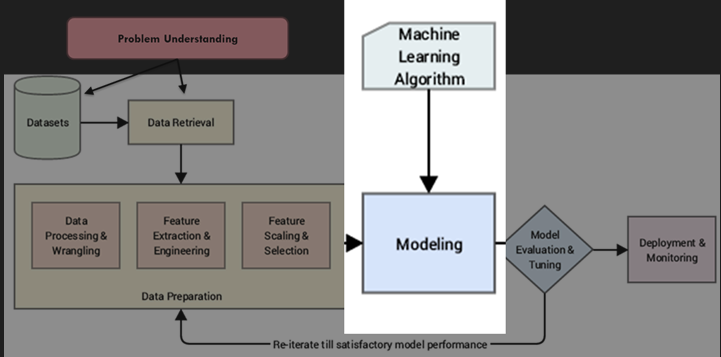

Una vez con el dataset de train preparado es hora de escoger algoritmos que se ajusten al problema que tenemos, que recordemos es de regresión. Además, en general, no escogeremos un único algoritmo sino varios para poder encontrar el que mejor se adapte a las características concretas de nuestro problema.  

Aunque lo hemos mencionado en la parte de evaluación que veremos en la siguiente sesión, este también es un buen momento para escoger una métrica de comparación y un sistema de validación de cuál de los modelos es mejor.

### 1. Métrica de Evaluación

Dedicaremos su sesión particular a las métricas, en este caso vamos a escoger como métrica una clásica en los problemas de regresión que: El error cuadrático medio o MSE (Mean Squared Error). Que se calcula como:

$$
\text{MSE} = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2
$$


Donde $y_i$ es el valor real de cada zona inspeccionada (en este ejemplo, es decir de cada instancia o fila del datset), $\hat y_i$ es el valor que da el modelo y n el número de instancias que se han evaluado por el modelo.

Utilizaremos la función que nos proporciona sklearn:

In [2]:
from sklearn.metrics import mean_squared_error

### 2. Sistema de validación/compración: Cross-Validation

El sitema que vamos a emplear para comparar los modelos creados con los algoritmos escogidos se denomina "validación cruzada" o cross-validation. Este es un método, que iremos viendo repetidas veces, y que es especialmente útil para comparar modelos y para evitar el problema del sobreajuste u overfitting [que veremos en la sesión en vivo]. Ahora mismo no hace falta que entremos en detalles. Lo veremos al comparar los dos modelos escogidos.

### 3. Algoritmos o técnicas escogidas

Aquí vamos a dar un salto de fe y vamos a escoger "Regresión Lineal" y "Arboles de Decisión para Regresión". No le des vueltas, cada uno tendrás su unidad particular. Simplemente mira como se crean los modelos:

In [3]:
# Regresor Lineal

from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()

# Arboles de decisión para Regresión 
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state = 42) # Necesita una inicialización aleatoria y la semilla permite que siempre sea la misma

### 4. Entrenando los modelos

In [4]:
# primero separamos la variable target del dataset de train y además solo nos quedamos con las features:

X = train_set[features].copy()
y= train_set[target]

Y ahora entrenamos/creamos el modelo para cada algoritmo:

In [5]:
lin_reg.fit(X,y)
tree_reg.fit(X,y)

DecisionTreeRegressor(random_state=42)

### 5. Primera evaluación: Evaluación contra los propios datos de entrenamiento

Aunque la fase de evaluación la contemplamos en la siguiente sesión, podemos hacer una primera evaluación sobre los mismos datos de entrenamiento. Es decir, generamos las predicciones que haría el modelo para los datos con los que ha entrenado y las comparamos con los datos reales. 

In [6]:
# Primero las predicciones
train_pred_lin = lin_reg.predict(X)

train_pred_tree = tree_reg.predict(X)

In [7]:
train_pred_lin

array([301644.,  74884., 267784., ..., 168020., 153604.,  52788.])

Y ahora MSE:

In [8]:
mse_lin = mean_squared_error(y, train_pred_lin, squared=False) # En realidad damos la raíz cuadrada del error cuadrático medio
# que está en las mismas unidades que el target
print(mse_lin)

76780.43538505519


In [9]:
mse_tree = mean_squared_error(y, train_pred_tree, squared= False)
print(mse_tree)

0.0


Uauhhh, el regresor de árboles lo clava!!!! Ya está tenemos un modelo perfecto... ¿o no? Lo veremos en la siguiente sesión.


## ML INTRO PRACTICA (VI): Evaluación y Ajuste

Comenzamos donde lo dejamos en la sesión anterior con el asombroso resultado de que el decisor de árboles tenia un cero de error. Y ahí va la primera gran advertencia: si el modelo sale perfecto o muy bueno, desconfia. Algo extraño hay. En este caso en concreto lo que ha ocurrido es sencillo de explicar: Sobreajuste u *Overfitting*

### Overfitting

El sobreajuste o overfitting es la capacidad de los modelos de adaptarse completamente a los datos de entrenamiento (de memorizarlos de alguna forma) de tal manera que el error de train es muy pequeño o muy inferior al error de validación o test.

Estos dos errores son los que se obtienen al aplicar el modelo al set de datos de Test o de Validación. 

### Validación Cruzada

Nosotros no hemos reservado datos para un set de validación porque hemos comentado que usaríamos validación cruzada. Y eso haremos. Básicamente vamos a reentrenar el los modelos con las dos técnicas elegidas con unos datasets de entrenamiento creados a partir del dataset completo de entrenamiento. Luego evaluaremos esos submodelos para cada ténica y la métrica será la media de las métricas para cada modelo.  

El proceso es el siguiente:

1. Dividiremos el dataset de train en "k" grupos (depende del total de datos que tengamos). 

2. Entrenaremos un modelo para cada combinación de k-1 grupos posibles (si tengo k = 5 por ejemplo tendré 5 posibles combinaciones, ver la tabla más abajo). Evaluaremos con el grupo restante.

3. La métrica a considerar será la media de las obtenidas en cada uno de las evaluaciones hechas.



| Ronda     | Fold 1    | Fold 2    | Fold 3    | Fold 4    | Fold 5    |
|-----------|-----------|-----------|-----------|-----------|-----------|
| 1         | Test      | Training  | Training  | Training  | Training  |
| 2         | Training  | Test      | Training  | Training  | Training  |
| 3         | Training  | Training  | Test      | Training  | Training  |
| 4         | Training  | Training  | Training  | Test      | Training  |
| 5         | Training  | Training  | Training  | Training  | Test      |


Usaremos una función de python no tendrás que hacer nada en especial:

In [10]:
from sklearn.model_selection import cross_val_score


#### Modelo construido con Regresión Lineal


In [11]:
#### Error contra todo el train:
train_pred_lin = lin_reg.predict(X)
mse_lin = mean_squared_error(y, train_pred_lin, squared=False) # En realidad damos la raíz cuadrada del error cuadrático medio
# que está en las mismas unidades que el target
print(mse_lin)

76780.43538505519


In [12]:
lin_rmses = -cross_val_score(lin_reg, X, y,   #--> (-) porque es el negado, para obtener el valor positivo
                              scoring="neg_root_mean_squared_error", cv=10) # k = 10
pd.Series(lin_rmses).describe()

count       10.000000
mean     76827.055349
std       2020.408608
min      73113.421646
25%      75813.051558
50%      77286.416014
75%      78358.031249
max      79045.240034
dtype: float64

Compara el error que teníamos de train con el obtenido mediante Cross Validation:

$$76780\ vs. \ 76827$$

El error será mejor o peor en función de las expectativas de "California Real State Investment Funds" pero se puede esperar que generalice bien (es decir que haya poco overfitting). Veamos que tal los árboles.

#### Modelo construido con Árboles de regresión

In [13]:
#### Error contra todo el train:
train_pred_tree = tree_reg.predict(X)
mse_tree = mean_squared_error(y, train_pred_tree, squared=False) # En realidad damos la raíz cuadrada del error cuadrático medio
# que está en las mismas unidades que el target
print(mse_tree)

0.0


In [14]:
tree_rmses = -cross_val_score(tree_reg, X, y,
                              scoring="neg_root_mean_squared_error", cv=10) # k = 10
pd.Series(tree_rmses).describe()

count        10.000000
mean      98229.945774
std        1731.305230
min       95557.734996
25%       97128.198619
50%       97647.697767
75%       99776.831156
max      100954.557331
dtype: float64

Comparando el error que teníamos de train con el obtenido mediante Cross Validation:

$$0\ vs. \ 98229$$

No sólo generaliza mucho peor (el error de validacion es muy superior al de train, hay claramente overfitting) sino además podemos esperarnos que sea peor ese error.


### Escoger Modelo:

Viendo los resultados de la validación cruzada, escogeremos, para este caso **el modelo creado con regresión lineal** (repito, para este caso)


### Ajustar Modelo

Este es el momento en el que podemos tocar los hiperparámetros del modelo e ir ajustándolos hasta llegar al modelo de regresión lineal (para nuestro problema) con las mejores prestaciones (siempre usando cross-validation)

Como los hiperparámetros de cada modelado o técnica son específicos, trataremos el ajuste de forma específica con cada uno. 



### Evaluación contra Test:

Lo primero que hay que hacer es aplicar las mismas transformaciones al Test que al train, además con rigor (sobre todo en los escalados, aunque aquí no lo vamos a hacer así exactamente):

In [15]:
test_set["income_cat"] = pd.cut(test_set["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

test_set["rooms_per_house"] = test_set["total_rooms"] / test_set["households"]
test_set["bedrooms_ratio"] = test_set["total_bedrooms"] / test_set["total_rooms"]



target = "median_house_value"

# Procesado de variables categóricas
test_set = pd.get_dummies(test_set, columns = ["ocean_proximity"], dtype = int)

# Procesado de variables numéricas
min_max_scaler = MinMaxScaler(feature_range=(-1, 1)) # ESTO NO ES FORMALMENTE CORRECTO, lo veremos en la sesión en vivo
for col in ["rooms_per_house","total_rooms","bedrooms_ratio"]:
    test_set[f"log_{col}"] = test_set[col].apply(np.log)
    test_set[col] = min_max_scaler.fit_transform(test_set[[f"log_{col}"]])

test_set["housing_median_age"] = min_max_scaler.fit_transform(test_set[["housing_median_age"]])


# Features finales
features = ['ocean_proximity_<1H OCEAN', 'ocean_proximity_INLAND',
       'ocean_proximity_ISLAND', 'ocean_proximity_NEAR BAY',
       'ocean_proximity_NEAR OCEAN', "income_cat", "rooms_per_house","total_rooms","housing_median_age","bedrooms_ratio"]


X_test = test_set[features].copy()
y_test = test_set[target]




Y ahora ya predecimos y evaluamos:


In [16]:
test_predict = lin_reg.predict(X_test)
mse_lin_test = mean_squared_error(y_test, test_predict, squared= False)
print(mse_lin_test)

77300.56986965699


Como esperábamos, aunque nos ha salido ligeramente superior al error obtenido con la validación cruzada es muy similar en test al de train. Esto es un caso de alto bias (error en train alto) y low variance (diferencia de error en train y test baja).

$$76780\ vs. \ 77300$$